In [164]:
from sympy import init_session
import math
import matplotlib.pyplot as plt
import sys
import ipywidgets as widgets
import numpy as np
import imageio.v2 as imageio
from IPython.display import Image
import pandas as pd
import seaborn as sns
init_session(use_latex = True)

IPython console for SymPy 1.13.2 (Python 3.10.1-64-bit) (ground types: gmpy)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.13.2/



In [192]:
# Size
a = 1.97 * 0.0254 #m R2
b = 12.4 * 0.0254 #m R3
c = 3.17 * 0.0254 #m R4
d = 13.4 * 0.0254 #m R1
a, b, c, d

In [250]:
m = 0.5 #kg
l = 24.5 * 0.0254 #length of wiper m
I = 1/3 * m * (l)**2 #moment of inertia about com kgm^2
mu_k = 0.3  # coefficient of kinetic friction
g = 9.81  # gravity (m/s^2)
theta = 25 #degs

In [251]:
#Parameters
motor_torque = 30 #NM 
df = pd.read_csv("4bardata.txt", sep='\t' , header = None, names = ["theta_2 [rad]", "theta_3 [rad]", "theta_4 [rad]", "theta_2 [°]","theta_3 [°]","theta_4 [°]","omega_2 [rad/s]", "omega_43 [rad/s]","omega_4 [rad/s]","alpha_2 [rad/s^2]","alpha_3 [rad/s^2]","alpha_4 [rad/s^2]"])
#df.head(20)
#print(df.shape[0])
list(df)

['theta_2 [rad]',
 'theta_3 [rad]',
 'theta_4 [rad]',
 'theta_2 [°]',
 'theta_3 [°]',
 'theta_4 [°]',
 'omega_2 [rad/s]',
 'omega_43 [rad/s]',
 'omega_4 [rad/s]',
 'alpha_2 [rad/s^2]',
 'alpha_3 [rad/s^2]',
 'alpha_4 [rad/s^2]']

In [252]:
#Torque Calculations
f1 = []
theta_a = []
for i in range(df.shape[0]):
    theta_a = (360 - (df["theta_2 [°]"][i]+ 180- df["theta_4 [°]"][i] + abs(- df["theta_3 [°]"][i]- df["theta_4 [°]"][i])))
    if ((df["theta_2 [°]"][i])>0).any() & ((df["theta_2 [°]"][i]) <= 90).any() & (theta_a >= 90).any():
        temp1 =  motor_torque * (np.sin(np.radians(df["theta_2 [°]"][i])) * a)
        f1.append(temp1)
    elif ((df["theta_2 [°]"][i])>90).any() & (theta_a <= 90).any():
        temp2 =  motor_torque * (np.sin(np.radians(theta_a)) * a)
        f1.append(temp2)
    elif (theta_a > 90).any() & ((df["theta_2 [°]"][i])>90).any(): 
        temp3 = motor_torque * (np.sin(np.pi-np.radians(theta_a)) * a)
        f1.append(temp3)
    else:
        temp4 = motor_torque * a
        f1.append(temp4)
        print("bug")

tau_out = []
theta_b = []
for j in range(df.shape[0]):
    theta_b =  (- df["theta_3 [°]"][j]- df["theta_4 [°]"][j])
    if ((df["theta_4 [°]"][j]) > 0).any() & ((df["theta_4 [°]"][j]) <= 90).any():
        temp5 = f1[j] * np.sin(np.radians(theta_b)) * c
        tau_out.append(temp5)  
    elif((df["theta_4 [°]"][j]) > 90).any() & ((df["theta_4 [°]"][j]) <= 180).any():
        temp6 = f1[j] * np.sin(np.radians(180 - theta_b)) * c
        tau_out.append(temp6) 

bug
bug
bug
bug


In [257]:
# Equations of Motion
# Moment about G (insert correct variables)
# Reordered the equation I * df["alpha_4 rad/s^2"] = tau_out - mu_k * F_n * l/2 to solve for F_n
acceleration_x = []
acceleration_y = []
acceleration_total = []
F_n = []
F_friction = []

for i in range(df.shape[0]):
    temp7 = - 2 * (I * df["alpha_4 [rad/s^2]"][i] - tau_out[i]) / (mu_k * l)
    F_n.append(temp7)
    # Sum of Forces x
    
    temp8 = 1/m * (tau_out[i]/l - F_n[i] * mu_k ) 
    acceleration_x.append(temp8)

    # Sum of Forces y
    # Reordered the equation m * acceleration_y = F_n - m * g * np.cos(25 * (pi/180)) to solve for acceleration_y
    temp11 = F_n[i] - m * g * np.cos(np.radians(theta)) / m
    acceleration_y.append(temp11)
    temp9 = (acceleration_x[i]**2 + acceleration_y[i]**2)**0.5
    acceleration_total.append(temp9)

    # Friction
    temp12 = mu_k * F_n[i]
    F_friction.append(temp12)


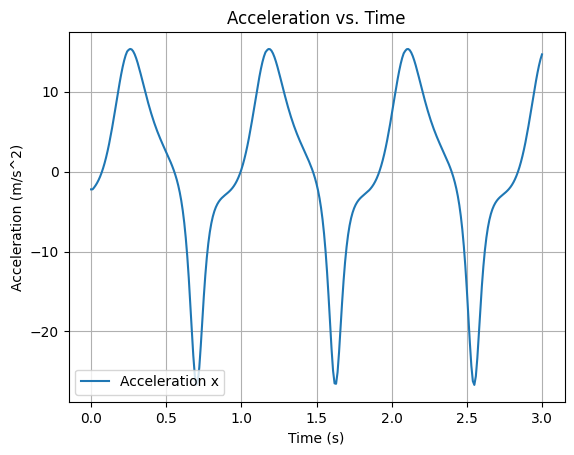

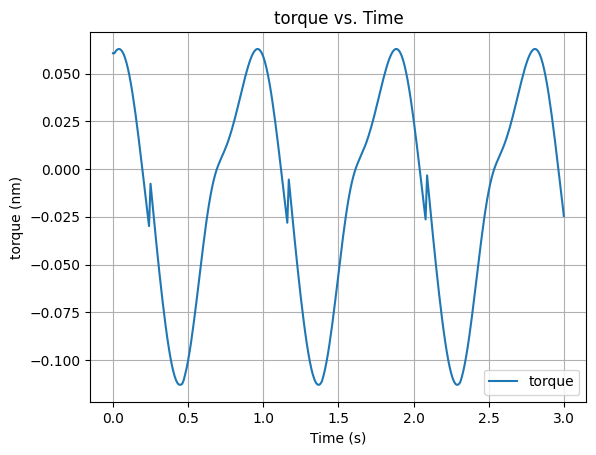

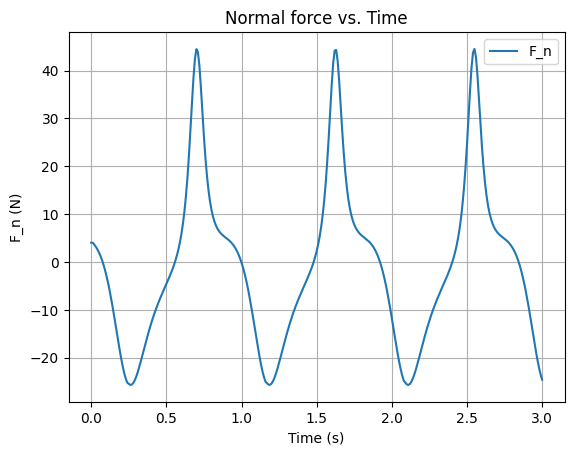

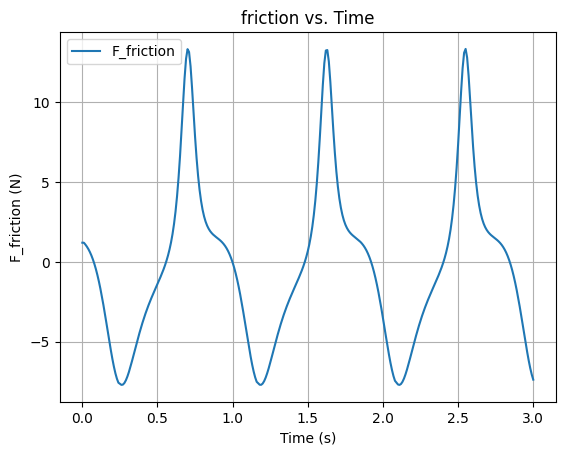

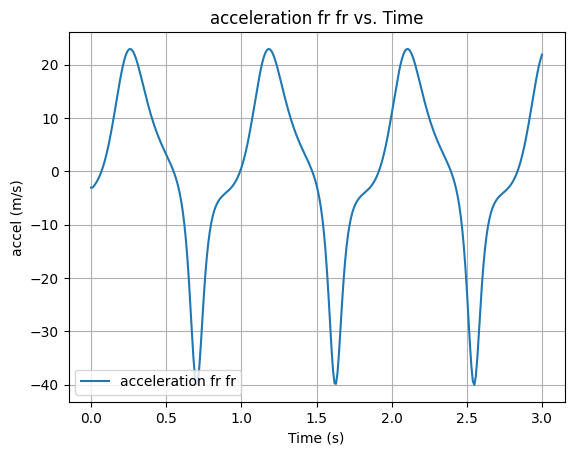

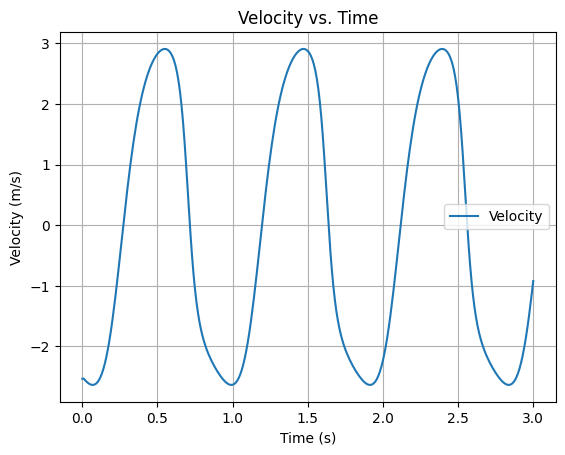

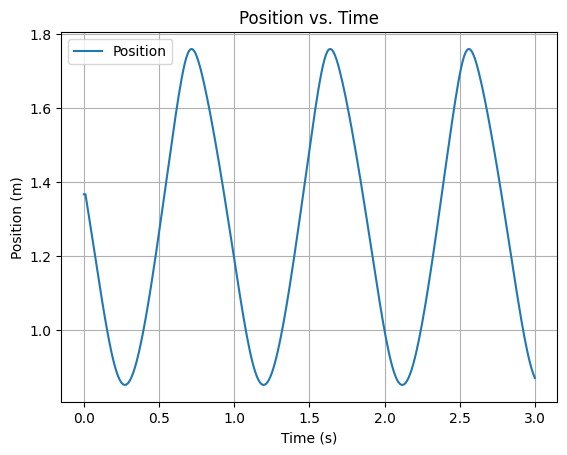

In [255]:
# Plotting the graphs
time = np.linspace(0,3,301)
plt.plot(time, acceleration_x, label='Acceleration x')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Acceleration vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(time, tau_out, label='torque')
plt.xlabel('Time (s)')
plt.ylabel('torque (nm)')
plt.title('torque vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(time, F_n, label='F_n')
plt.xlabel('Time (s)')
plt.ylabel('F_n (N)')
plt.title('Normal force vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(time, F_friction, label='F_friction')
plt.xlabel('Time (s)')
plt.ylabel('F_friction (N)')
plt.title('friction vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(time, l * df["alpha_4 [rad/s^2]"], label='acceleration fr fr')
plt.xlabel('Time (s)')
plt.ylabel('accel (m/s)')
plt.title('acceleration fr fr vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(time, l * df["omega_4 [rad/s]"], label='Velocity')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity vs. Time')
plt.legend()
plt.grid()
plt.show()

plt.plot(time, l * df["theta_4 [rad]"], label='Position')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.title('Position vs. Time')
plt.legend()
plt.grid()
plt.show()